In [1]:
import numpy as np 
import pandas as pd
from mlp import mlp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import copy
import datetime

In [89]:
df = pd.read_csv("./dataset/BTC-USD.csv")[-500:]
print "First:", df.Date.values[0]
print "Last:", df.Date.values[-1]
df.Dates = pd.to_datetime(df.Date)
print df.head(), "\n", len(df)
short_term = 7
long_term = 30

First: 2017-02-27
Last: 2018-07-17
            Date         Open         High          Low        Close  \
2417  2017-02-27  1171.579956  1195.819946  1164.270020  1188.829956   
2418  2017-02-28  1188.829956  1208.219971  1175.750000  1189.270020   
2419  2017-03-01  1189.270020  1225.040039  1154.550049  1222.660034   
2420  2017-03-02  1222.660034  1286.979980  1211.959961  1255.469971   
2421  2017-03-03  1255.469971  1291.349976  1250.800049  1283.300049   

        Adj Close    Volume  
2417  1188.829956  42035366  
2418  1189.270020  60371869  
2419  1222.660034  61964760  
2420  1255.469971  98040639  
2421  1283.300049  85876262   
500


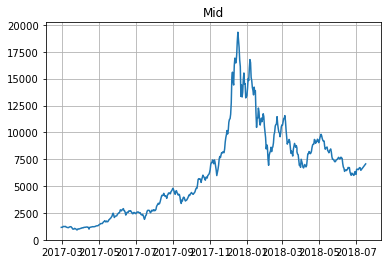

(500,)


In [90]:
%matplotlib inline
mid = ((df.High + df.Low)/2.)
plt.plot(df.Dates, mid)
plt.grid()
plt.title("Mid")
plt.show()
print mid.shape

## Cross analisys

In [82]:
def death_cross(a, b, long_days=30, short_days=0, xlabels=None):
    m = a.shape[0]
    a_n = []
    b_n = []
    x_n = []
    for i in xrange(long_days, m):
        a_n.append(a[(i-long_days):i].mean()) 
        b_n.append(b[(i-short_days):i].mean())
        if xlabels is not None:
            x_n.append(xlabels[i-1])
            
    if xlabels is not None:
         return np.hstack((x_n)),np.hstack((a_n)), np.hstack((b_n))
    else:
        return np.hstack((a_n)), np.hstack((b_n))

def tscore(y_real, y_pred):
    
    pred_diff = y_pred[1:] - y_pred[:-1]
    real_diff = y_real[1:] - y_real[:-1]
    
    real_bin = np.where(1, real_diff>0, 0)
    pred_bin = np.where(1, pred_diff>0, 0)

    bn =  (y_real.shape[0] - np.count_nonzero(pred_bin - real_bin, axis=0))/float(y_real.shape[0])
    return bn

In [83]:
xlabels, longterm, shortterm = death_cross(mid.values, mid.values,
                                           long_days=long_term, short_days=short_term, xlabels=df.Dates.values)

In [84]:
def long_cross(long_term, short_term, xlabels=None):
    lo = long_term.shape[0]
    crosses = []
    labels = []
    greater = True
    prev_greater = True
    for i in xrange(lo):
        if long_term[i] >= short_term[i]:
            greater = True
        else:
            greater = False
            
        if (greater == prev_greater):
            crosses.append(long_term[i])
            labels.append(xlabels[i])
            prev_greater = not(greater)
            
    if xlabels is None:
        return np.hstack((crosses))
    else: 
        return np.hstack((labels)), np.hstack((crosses))
    
lcrosses, crosses = long_cross(longterm, shortterm, xlabels)

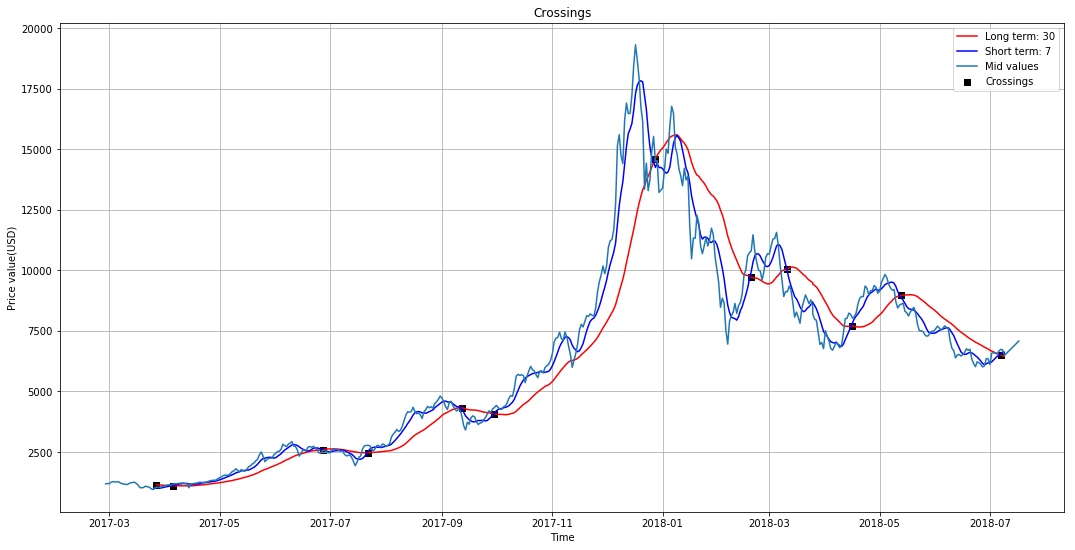

In [85]:
%matplotlib inline

plt.figure(figsize = (18,9))
plt.plot(xlabels, longterm, c="r", label="Long term: %s"%long_term)
plt.plot(xlabels, shortterm, c="b", label="Short term: %s"%short_term)
plt.plot(df.Dates, mid, label="Mid values")
plt.scatter(lcrosses, crosses, c="k",marker="s", label="Crossings")
plt.grid()
plt.legend(loc="best")
plt.title("Crossings")
plt.xlabel("Time")
plt.ylabel("Price value(USD)")
plt.show()

## Do highs move faster than lows?

In [115]:
p = tscore(df.Low.values, df.High.values)
print ">>In %.2f%% of the cases, the high follows the low (and vice versa), but in %.2f%% it surprisingly does not happen."%(p*100, (1-p)*100)
print "Temporaly speaking"

>>In 76.60% of the cases, the high follows the low (and vice versa), but in 23.40% it surprisingly does not happen.
Temporaly speaking


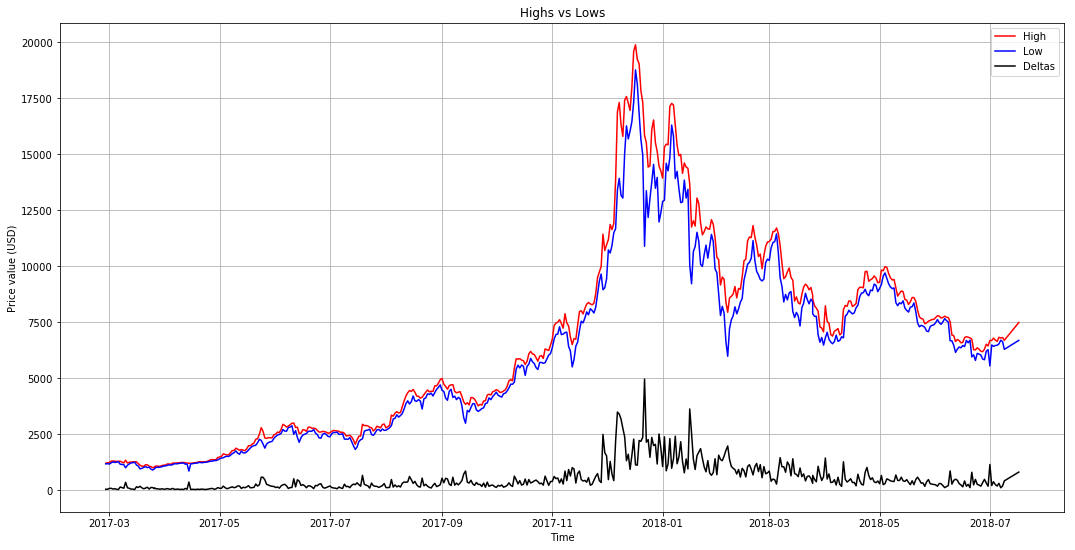

In [155]:
deltas = df.High.values-df.Low.values

plt.figure(figsize = (18,9))
plt.plot(df.Dates.values, df.High.values, c="r", label="High")
plt.plot(df.Dates.values, df.Low.values, c="b", label="Low")
plt.plot(df.Dates.values, deltas, c="k", label="Deltas")


plt.grid()
plt.legend(loc="best")
plt.title("Highs vs Lows")
plt.xlabel("Time")
plt.ylabel("Price value (USD)")
plt.show()


## Looking at the Pearson coefficient (linear)

In [124]:
np.corrcoef(deltas, mid.values)

array([[1.        , 0.74312826],
       [0.74312826, 1.        ]])

In [127]:
deltas

array([1.02709846, 1.02761639, 1.06105408, 1.06189975, 1.03241919,
       1.04643009, 1.02510269, 1.01555114, 1.11511672, 1.0924988 ,
       1.0687298 , 1.34563922, 1.0886239 , 1.06422598, 1.03319483,
       1.03048311, 1.01659608, 1.12626013, 1.10476929, 1.17382841,
       1.09961651, 1.05218647, 1.07822816, 1.12437609, 1.03989161,
       1.11972829, 1.11851581, 1.06092007, 1.09050737, 1.05215424,
       1.04990381, 1.03107955, 1.05121804, 1.03397755, 1.03283345,
       1.05688462, 1.03479028, 1.0304307 , 1.06283893, 1.02390931,
       1.02706034, 1.03501732, 1.01678923, 1.02827485, 1.01499137,
       1.05943718, 1.0286019 , 1.41985424, 1.01819598, 1.02571594,
       1.01909095, 1.02020803, 1.0297108 , 1.0173281 , 1.03387944,
       1.02712044, 1.01741088, 1.02283379, 1.03657953, 1.04784096,
       1.05322225, 1.02247834, 1.03762801, 1.07886625, 1.05470922,
       1.05079875, 1.1201926 , 1.06942712, 1.03756158, 1.05197365,
       1.07393459, 1.08482876, 1.06077518, 1.07075345, 1.11048